# Análise de avaliações de hotéis

Este *notebook* visa demonstrar o passo-a-passo de uma análise de avaliações de hotéis, realizadas com o método de aprendizado supervisionado *Random Forest*, cujo objetivo é prever se uma determinada avaliação é positiva ou negativa. Para melhorar a acurácia das predições, utilizaremos alguns métodos de manipulação e contagem das palavras nas avaliações. 

### 1. Observação inicial dos dados

Primeiramente, vamos fazer uma breve análise dos dados. Para tal, é necessário utilizar a biblioteca *liac-arff*, que implementa funções para ler e gravar arquivos ARFF em Python, e a *pandas*, que é uma ferramenta para estrutura e análise de dados.

In [1]:
!pip install liac-arff
import arff
import pandas as pd

Com as bibliotecas carregadas, vamos importar o arquivo contendo os dados, e convertê-lo para tipo *Dataframe* da biblioteca *pandas*, a fim de ser melhor manipulado. Após, vamos definir os rótulos para as colunas do *Dataframe* - o *label* é a coluna *class*, que contém a informação se a avaliação é positiva ou negativa, e a coluna *text*, que é o texto da avaliação. Por fim, vamos visualizar os primeiros registros da base.

In [2]:
dataset = arff.load(open('data/hoteis.arff', 'r'))
data = pd.DataFrame(dataset['data'])
data.columns = ['text', 'class'] 

data.head()                         

,text,class
0,vocês são o melhor,pos
1,foi muito grato trabalhar com voces,pos
2,realizei o aniversario de meu sobrinho na terc...,pos
3,gostei muito do atendimento personalizado/n,pos
4,"grande hotel com otimas acomodacoes, a beira d...",pos


Abaixo, visualizamos a quantidade de (linhas, colunas)

In [3]:
data.shape

(411, 2)

Existem valores nulos (por coluna)?

In [4]:
data.isna().any()

text     False
class    False
dtype: bool

Quantidade de avaliações positivas e negativas

In [5]:
data['class'].value_counts()

pos    207
neg    204
Name: class, dtype: int64

### 2. Separação dos dados

Agora, vamos separar os dados em um grupo de treino e outro de teste, e para isso vamos utilizar a *sklearn.model_selection*, que compara, valida e escolhe parâmetros e modelos. Definimos uma variável X que contém os dados sem o *label*, cujo nome definimos como *class*. O parâmetro *axis=1* estabelece que a definição das colunas a serem excluídas será pelo nome da coluna. Na variável Y, são inseridos os dados da *class*. Com o método *train_test_spit*, separamos dados de treino e teste de forma aleatória, com tamanho do conjunto de teste sendo 20% do total da base, e com o atributo *random_state* definindo que a semente (pseudo-)aleatória é 10.

In [6]:
from sklearn.model_selection import train_test_split

X = data.drop('class', axis=1).values 
y = data['class'].values

train_features, test_features, class_train, class_test = train_test_split(X, y, test_size=0.20, random_state=10)

### 3. StopWords

Vamos utilizar o pacote *stopwords*, presente na biblioteca *nltk* (que auxilia a construir programas para trabalhar com dados em linguagem humana), a fim de retirar das avaliações as *stop words* presentes nas frases.

In [7]:
!pip install nltk
import nltk # 
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mariana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 4. CountVectorizer

A biblioteca *sklearn* extrai recursos em um formato suportado por algoritmos de aprendizado de máquina a partir de conjuntos de dados. A classe *CountVectorizer* faz parte dessa biblioteca, e fornece uma maneira simples de tokenizar uma coleção de documentos de texto e construir um vocabulário de palavras conhecidas. Com ela, podemos criar uma matriz com a quantidade de vezes que cada palavra foi utilizada em cada frase.

Na nossa análise, utilizaremos a *CountVectorizer* para os dados com e sem *stop words*.

Abaixo, é criada a matriz com a contagem de cada token **sem** *stop words*. O método *fit_transform* da classe *CountVectorizer* processa os dados e retorna a matriz com tokens; *ravel* "nivela" os *arrays*. O método *transform* aplica o mesmo procedimento na base de teste.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

cv_train_features = cv.fit_transform(train_features.ravel()) 
cv_test_features = cv.transform(test_features.ravel())

print('Shape das features (linhas, colunas) SEM stop words de treino {0} e de teste {1}'.format(cv_train_features.shape, cv_test_features.shape))

Shape das features (linhas, colunas) SEM stop words de treino (328, 2340) e de teste (83, 2340)


Abaixo, a *CountVectorizer* é utilizada para contar os tokens **com** *stop words*. 

In [9]:
cv_sw = CountVectorizer(stopwords.words('portuguese'))
cv_sw_train_features = cv_sw.fit_transform(train_features.ravel()) 
cv_sw_test_features = cv_sw.transform(test_features.ravel())

print('Shape das features (linhas, colunas) COM stop words de treino {0} e de teste {1}'.format(cv_sw_train_features.shape, cv_sw_test_features.shape))

Shape das features (linhas, colunas) COM stop words de treino (328, 2340) e de teste (83, 2340)


### 5. Funções Auxiliares

Abaixo definimos algumas funções para facilitar o uso de modelos e demonstrar os resultados dos mesmos. É importado o módulo *sklearn*, que inclui métricas de desempenho e cálculos de distâncias e métricas de pares.

In [10]:
from sklearn import metrics 

def train_predict_model(classifier, train_features, train_labels, test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features) 
    return predictions 

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], labels=level_labels)) 
    print(cm_frame) 

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):
    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, labels=classes) 
    print(report)

def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels), 4))
    print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels, average='weighted'), 4))
    print('Recall:', np.round( metrics.recall_score(true_labels, predicted_labels, average='weighted'), 4))
    print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels, average='weighted'), 4))
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, classes=classes)

### 6. Random Forest

Por fim, vamos utilizar o modelo Random Forest, que é um algoritmo de aprendizagem supervisionada, que utiliza métodos de comitês. Ele cria árvores de decisão e as combina para obter uma predição com maior acurácia.

Para tal, vamos utilizar a classe *RandomForestClassifier* com *n_jobs = -1*, que define que todos os processadores serão utilizados em paralelo para fazer o *fit* e prever. Essa classe faz parte da biblioteca *sklearn.ensemble*, que combina as predições de vários estimadores construídos com um dado algoritmo de aprendizado; e a *numpy*, que é uma das principais bibliotecas para computação científica.

In [11]:
from sklearn.ensemble import RandomForestClassifier 
import numpy as np

rfc = RandomForestClassifier(n_jobs=-1) 

#### 6.1 RF com stop words

In [12]:
rfc_tfidf_predictions = train_predict_model(classifier=rfc, train_features=cv_sw_train_features, train_labels=class_train,
                                            test_features=cv_sw_test_features, test_labels=class_test)

display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions, classes=['pos', 'neg'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Performance metrics:
------------------------------
Accuracy: 0.8434
Precision: 0.8436
Recall: 0.8434
F1 Score: 0.8434

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.85      0.83      0.84        42
         neg       0.83      0.85      0.84        41

   micro avg       0.84      0.84      0.84        83
   macro avg       0.84      0.84      0.84        83
weighted avg       0.84      0.84      0.84        83


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   pos neg
Actual: pos         35   7
        neg          6  35


#### 6.2 RF sem stop words

In [13]:
rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                            train_features=cv_train_features, train_labels=class_train,
                                            test_features=cv_test_features, test_labels=class_test)

display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'])

Model Performance metrics:
------------------------------
Accuracy: 0.7952
Precision: 0.7953
Recall: 0.7952
F1 Score: 0.7951

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.79      0.81      0.80        42
         neg       0.80      0.78      0.79        41

   micro avg       0.80      0.80      0.80        83
   macro avg       0.80      0.80      0.80        83
weighted avg       0.80      0.80      0.80        83


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   pos neg
Actual: pos         34   8
        neg          9  32


Após a execução do modelo com e sem *stop words*, podemos notar que a acurácia do modelo sem *stop words* é um pouco melhor do que o modelo com *stop words*, o que faz sentido, já que as *stop words* não tem significado positivo ou negativo, trazendo pouco impacto à predição da classificação da avaliação. Em uma base com um volume maior de dados, talvez a discrepância entre os valores fosse maior, fazendo jus à essa afirmação.

### 7. TF-IDF

O TD-IDF de uma coleção de documentos é uma medida que indica a importância das palavras presentes nele em relação à coleção. Para calcular essa medida, vamos utilizar a classe *TfidfVectorizer* presente na biblioteca *sklearn*. Os valores de *min_df* e *max_df* em seu construtor estabelecem que nenhuma palavra será ignorada, *sublinear_tf* diminui o "bias", e *ngram_range* define se serão gerados apenas *unigrams*, *bigrams*, e etc. Nessa análise, vamos realizar uma abordagem com *unigrams*, *unigrams e bigrams*, e *unigrams, bigrams e trigrams*, a fim de verificar qual tem a melhor performance.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

#### 7.1 TF-IDF com unigrams

In [15]:
tv_unigrams = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1), sublinear_tf=True) 
tv_train_features = tv_unigrams.fit_transform(train_features.ravel())
tv_test_features = tv_unigrams.transform(test_features.ravel())

print('Shape das features (linhas, colunas) de treino {0} e de teste {1}'.format(tv_train_features.shape, tv_test_features.shape))

rfc_tfidf_predictions = train_predict_model(classifier=rfc, train_features=tv_train_features, train_labels=class_train,
                                            test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'])

Shape das features (linhas, colunas) de treino (328, 2340) e de teste (83, 2340)
Model Performance metrics:
------------------------------
Accuracy: 0.8313
Precision: 0.8342
Recall: 0.8313
F1 Score: 0.8308

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.80      0.88      0.84        42
         neg       0.86      0.78      0.82        41

   micro avg       0.83      0.83      0.83        83
   macro avg       0.83      0.83      0.83        83
weighted avg       0.83      0.83      0.83        83


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   pos neg
Actual: pos         37   5
        neg          9  32


#### 7.2 TF-IDF com unigrams e bigrams

In [16]:
tv_unigrams = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
tv_train_features = tv_unigrams.fit_transform(train_features.ravel())
tv_test_features = tv_unigrams.transform(test_features.ravel())

print('Shape das features (linhas, colunas) de treino {0} e de teste {1}'.format(tv_train_features.shape, tv_test_features.shape))

rfc_tfidf_predictions = train_predict_model(classifier=rfc, train_features=tv_train_features, train_labels=class_train,
                                            test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'])

Shape das features (linhas, colunas) de treino (328, 9678) e de teste (83, 9678)
Model Performance metrics:
------------------------------
Accuracy: 0.8434
Precision: 0.8435
Recall: 0.8434
F1 Score: 0.8433

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.84      0.86      0.85        42
         neg       0.85      0.83      0.84        41

   micro avg       0.84      0.84      0.84        83
   macro avg       0.84      0.84      0.84        83
weighted avg       0.84      0.84      0.84        83


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   pos neg
Actual: pos         36   6
        neg          7  34


#### 7.3 TF-IDF com unigrams, bigrams e trigrams

In [17]:
tv_unigrams = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,3), sublinear_tf=True)
tv_train_features = tv_unigrams.fit_transform(train_features.ravel())
tv_test_features = tv_unigrams.transform(test_features.ravel())

print('Shape das features (linhas, colunas) de treino {0} e de teste {1}'.format(tv_train_features.shape, tv_test_features.shape))

rfc_tfidf_predictions = train_predict_model(classifier=rfc, train_features=tv_train_features, train_labels=class_train,
                                            test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'])

Shape das features (linhas, colunas) de treino (328, 18330) e de teste (83, 18330)
Model Performance metrics:
------------------------------
Accuracy: 0.759
Precision: 0.7685
Recall: 0.759
F1 Score: 0.7565

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.72      0.86      0.78        42
         neg       0.82      0.66      0.73        41

   micro avg       0.76      0.76      0.76        83
   macro avg       0.77      0.76      0.76        83
weighted avg       0.77      0.76      0.76        83


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   pos neg
Actual: pos         36   6
        neg         14  27


A acurácia com *TF-IDF* é um pouco menor do que com *CountVectorizer*. Além disso, podemos notar que quanto mais *n-grams* adicionamos, pior fica a acurácia. Com isso, o modelo com apenas *unigrams* é o mais indicado.

### 8. Stemmer

É um processo automatizado que retorna uma *string* de base, dada uma determinada *string*, a fim de encontrar palavras relacionadas, com mesma base. Para tal, vamos utilizar o pacote *rslp*, que é um removedor de sufixos da língua portuguesa, presente na biblioteca *nltk*. A classe *RSLPStemmer* presente nele é responsável por isso.

In [18]:
nltk.download('rslp') 
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mariana\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Novamente, vamos separar os *labels*, e após isso vamos remover o sufixo de cada palavra presente nas avaliações, para enfim separar os dados em treino e teste para verificar a performance.

In [19]:
y = data['class'].values

corpus = []
for review in data['text']:
    phrase = []
    for word in review.split():
        w_stemmed = stemmer.stem(word)
        phrase.append(w_stemmed)
    corpus.append(phrase)
    
train_features, test_features, class_train, class_test = train_test_split(corpus, y, test_size=0.20, random_state=10)

rfc_stem_predictions = train_predict_model(classifier=rfc, 
                                           train_features=tv_train_features, train_labels=class_train,
                                           test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_stem_predictions, classes=['pos', 'neg'])

Model Performance metrics:
------------------------------
Accuracy: 0.6988
Precision: 0.7078
Recall: 0.6988
F1 Score: 0.6948

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.67      0.81      0.73        42
         neg       0.75      0.59      0.66        41

   micro avg       0.70      0.70      0.70        83
   macro avg       0.71      0.70      0.69        83
weighted avg       0.71      0.70      0.69        83


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   pos neg
Actual: pos         34   8
        neg         17  24


A acurária utilizando *stemmer* é menor do que utilizando *TF-IDF* e *CountVectorizer*, talvez por conta da complexidade da língua portuguesa, esse método tenha obtido esse resultado.

### 9. Separação de palavras em avaliações positivas e negativas

Agora, vamos realizar a separação de palavras presentes em avaliações negativas e positivas, removendo as *stop words*, para plotá-las em uma *word cloud*.

#### 9.1 Separação de palavras em avaliações negativas

In [20]:
neg_phrases = data[data['class'] == 'neg']

neg_string = []
for phrase in neg_phrases['text']: 
    for word in phrase.split():
        if word not in stopwords.words('portuguese'):
            neg_string.append(word)

neg_text = pd.Series(neg_string).str.cat(sep=' ')

#### 9.2 Separação de palavras em avaliações positivas

In [21]:
pos_phrases = data[data['class'] == 'pos']
pos_string = []
for phrase in pos_phrases['text']:
    for word in phrase.split():
        if word not in stopwords.words('portuguese'):
            pos_string.append(word)

pos_text = pd.Series(pos_string).str.cat(sep=' ')

### 10. WordCloud

Com as palavras presentes em avaliações positivas e negativas, podemos plotá-las em uma *word cloud*, a fim de verificar as palavras que são mais utilizadas em cada tipo de avaliação. Para isso, vamos utilizar a biblioteca *wordcloud*, que gera *word clouds*, e o *framework matplotlib*, que plota dados da mesma forma que o *matlab*. Os parâmetros passados para os métodos das bibliotecas são para renderizar melhor a *word cloud*.

In [22]:
!pip install wordcloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

#### 10.1 Word Cloud de avaliações com palavras negativas

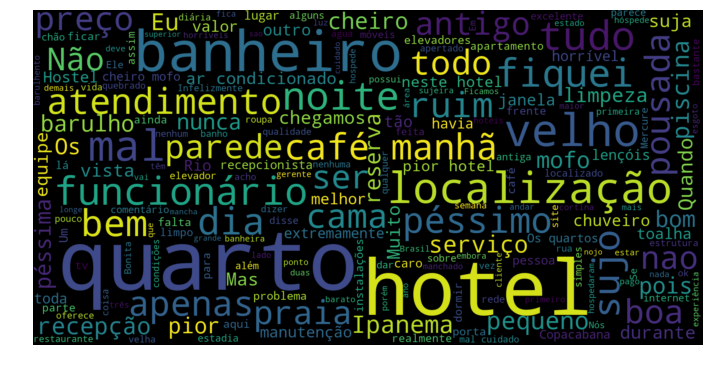

In [23]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 10.2 Word Cloud de avaliações com palavras positivas

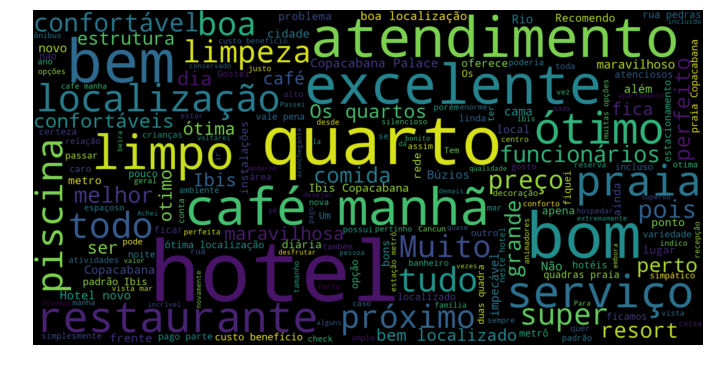

In [24]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 11. Créditos

Outros projetos que acrescentaram - e muito - em conhecimento para realizar essa análise.

[Intro to Movie Review Sentiment Analysis](https://www.kaggle.com/divsinha/sentiment-analysis-countvectorizer-tf-idf)


[Horse Colic : life or death](https://www.kaggle.com/surya635/horse-colic-life-or-death) 